# Model Training Iteration 1
Model training here contains:
- Dataset only sourced from the internet 
- Class imbalance solved via down sampling without replacement 
- Simple CNN architecture  

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

2024-03-13 06:50:10.951722: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 06:50:11.031561: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 06:50:11.031631: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 06:50:11.031659: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 06:50:11.046796: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 06:50:11.047877: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Constants

In [2]:
TARGET_WORD='marvin'
SEED= 324234
SPEECH_DATA='/src/voice_power/audio_data'

## Functions

In [3]:
def down_sample_dataset(X,Y,target_class,seed):
    np.random.seed(seed)
    positive_index=np.where(Y==target_class)[0]
    num_positive=len(positive_index)
    Y_with_positive=Y[positive_index]
    X_with_positive=X[positive_index]

    unique_class=np.unique(Y)
    unique_class_sub_positive=np.delete(unique_class,target_class)

    num_remaining_class=unique_class_sub_positive.shape[0]
    num_sample_per_remaining_class=int(len(positive_index)/num_remaining_class)

    balanced_samples=num_positive+num_remaining_class*num_sample_per_remaining_class
    X_balanced_shape=np.concatenate([[balanced_samples],X.shape[1:]])
    Y_balanced=np.empty((balanced_samples,),dtype=int)
    X_balanced=np.empty(X_balanced_shape,dtype=float)
    Y_balanced[:num_positive]=Y_with_positive
    X_balanced[:num_positive]=X_with_positive


    for i,remain_class in enumerate(unique_class_sub_positive):
        class_index=np.where(Y==remain_class)[0]
        sample_class_index=np.random.choice(class_index,size=num_sample_per_remaining_class,replace=False)
        start_index=num_positive+i*num_sample_per_remaining_class
        stop_index=num_positive+(i+1)*num_sample_per_remaining_class
        X_balanced[start_index:stop_index]=X[sample_class_index]
        Y_balanced[start_index:stop_index]=Y[sample_class_index]

    def binarizer(array_element,label):
        if array_element==label:
            return 1
        else:
            return 0

    v_binarizer=np.vectorize(binarizer)
    Y_balanced=v_binarizer(Y_balanced,target_class)

    return X_balanced,Y_balanced

    


## Processing data 

In [4]:
def list_subfolders(folder_path):
    subfolders = [f.path[len(folder_path)+1:] for f in os.scandir(folder_path) if f.is_dir()]
    return subfolders

words = list_subfolders(SPEECH_DATA)
target_class=words.index(TARGET_WORD)

In [5]:
# Load up the sprectrograms and labels
training_spectrogram = np.load('/src/voice_power/processed_data/training_spectrogram.npz')
validation_spectrogram = np.load('/src/voice_power/processed_data/validation_spectrogram.npz')
test_spectrogram = np.load('/src/voice_power/processed_data/test_spectrogram.npz')

In [6]:
# extract the data from the files
X_train = training_spectrogram['X']
Y_train = training_spectrogram['Y']
X_validate = validation_spectrogram['X']
Y_validate = validation_spectrogram['Y']
X_test = test_spectrogram['X']
Y_test = test_spectrogram['Y']

# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

In [7]:
#balancing the dataset
X_train_bal,Y_train_bal=down_sample_dataset(X_train,Y_train,target_class,SEED)
X_validate_bal,Y_validate_bal=down_sample_dataset(X_validate,Y_validate,target_class,SEED)
X_test_bal,Y_test_bal=down_sample_dataset(X_test,Y_test,target_class,SEED)

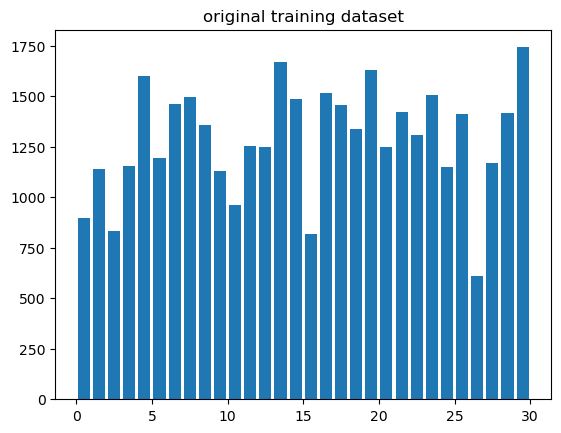

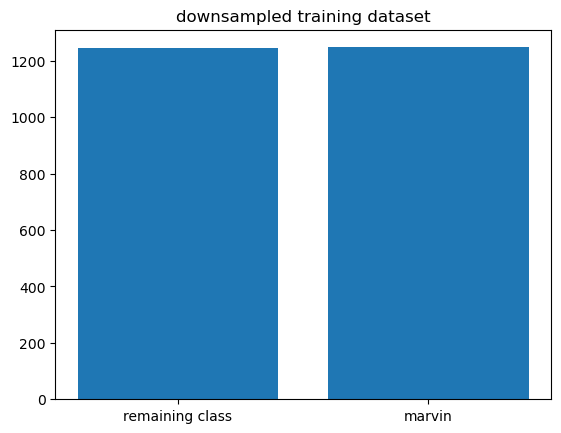

In [8]:
plt.hist(Y_train,bins=range(0,len(np.unique(Y_train))+1),rwidth=0.8)
plt.title('original training dataset')
plt.show()

plt.hist(Y_train_bal,bins=range(0,len(np.unique(Y_train_bal))+1),rwidth=0.8)
plt.xticks([0.5,1.5],['remaining class','marvin'])
plt.title('downsampled training dataset')
plt.show()

## Exploring training dataset 

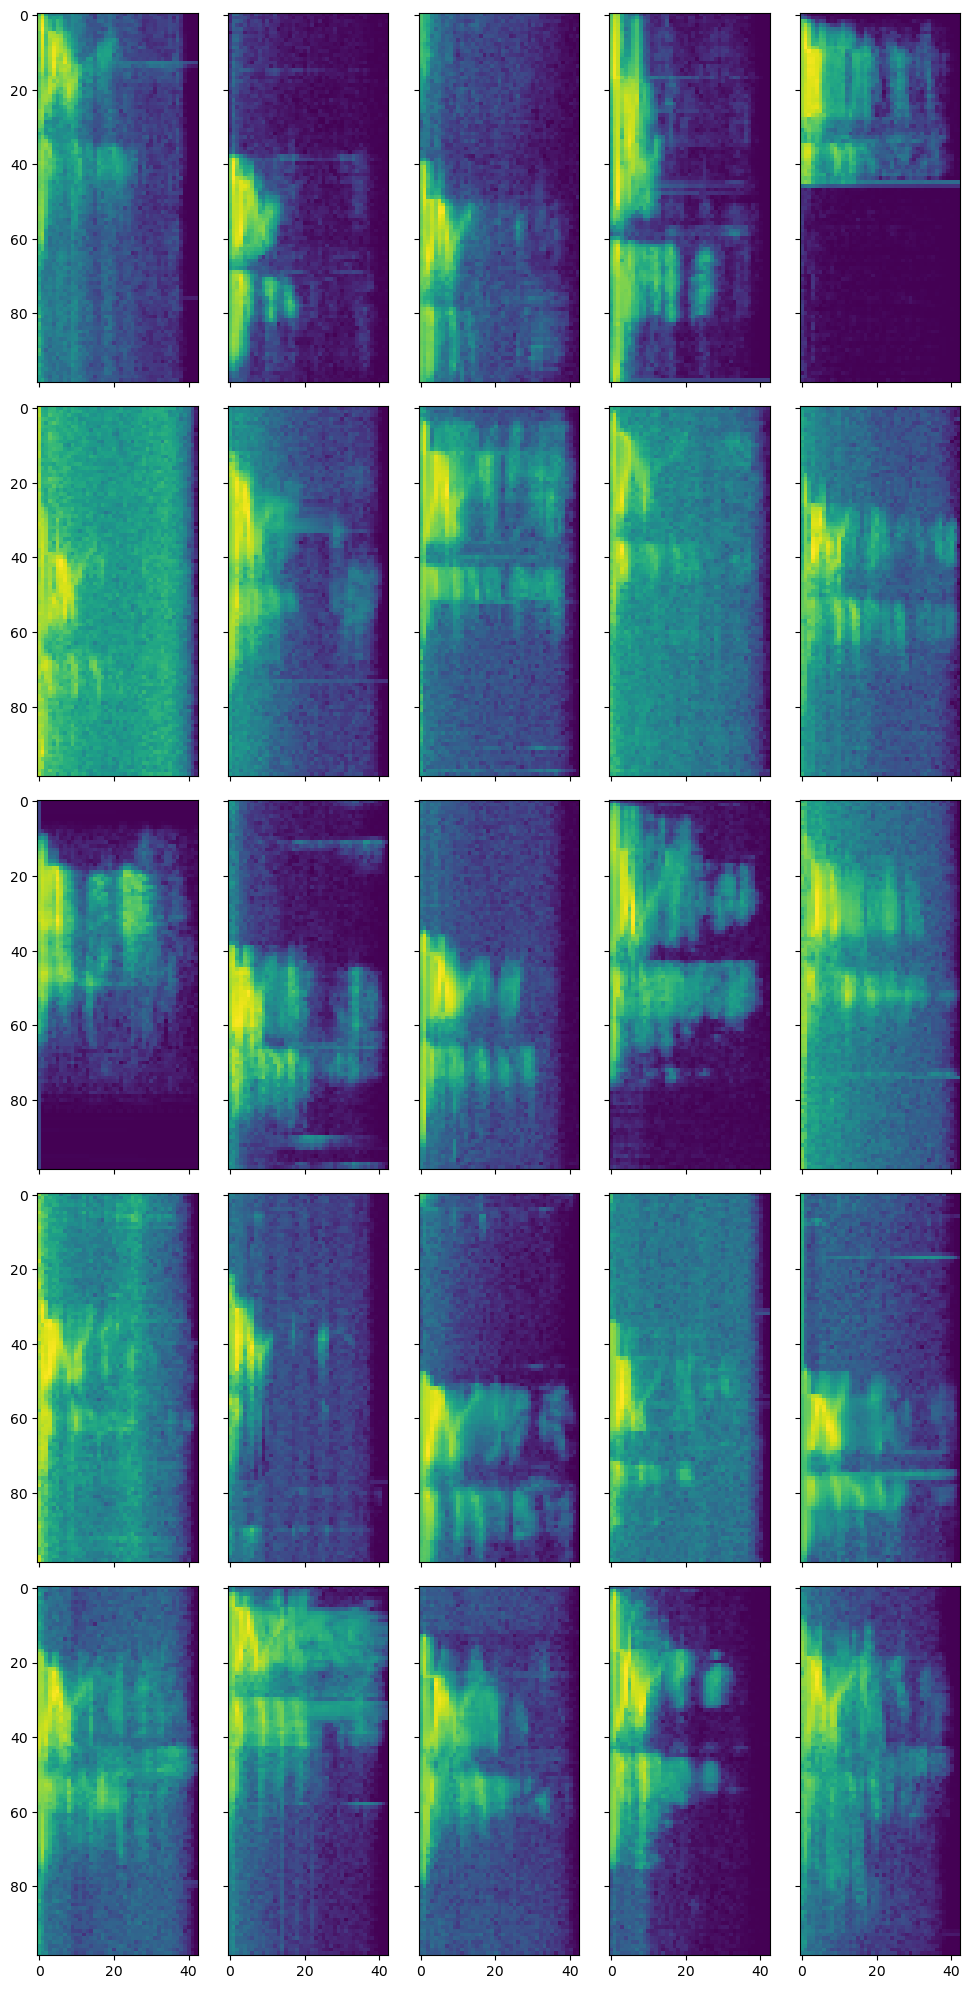

In [9]:
#exploring the target class
check=np.where(Y_train_bal==1)[0]
check25=np.random.choice(check,size=25,replace=False)

fig,axes=plt.subplots(5,5,sharex=True,sharey=True,figsize=(10, 20))

axes=axes.flatten()

for img,ax in zip(X_train_bal[check25],axes):
    ax.imshow(img)

plt.tight_layout()


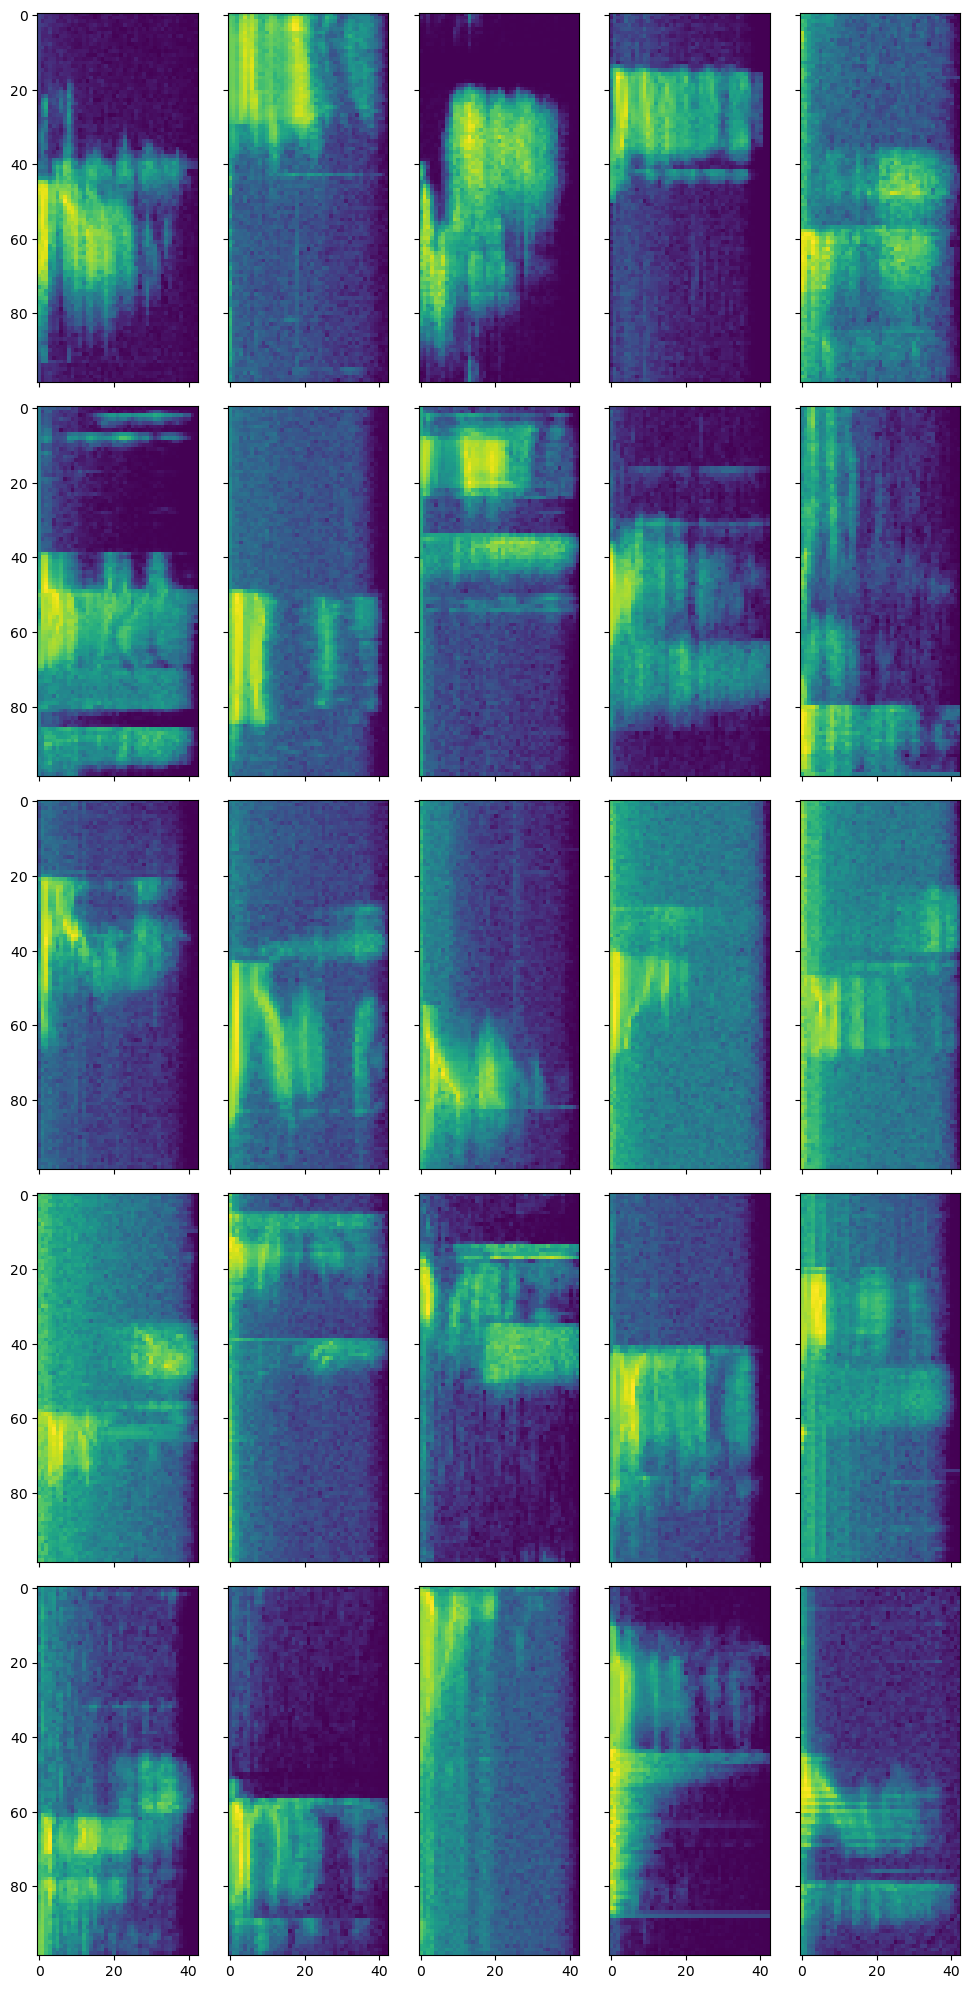

In [10]:
#exploring the non-target class
check=np.where(Y_train_bal==0)[0]
check25=np.random.choice(check,size=25,replace=False)

fig,axes=plt.subplots(5,5,sharex=True,sharey=True,figsize=(10, 20))

axes=axes.flatten()

for img,ax in zip(X_train_bal[check25],axes):
    ax.imshow(img)

plt.tight_layout()

## Training 

In [73]:
tf.keras.backend.clear_session()

model = Sequential([
    Conv2D(4, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer1',
           input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
    MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
    Conv2D(4, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer2'),
    MaxPooling2D(name='max_pooling2', pool_size=(2,2)),
    Flatten(),
    Dropout(0.2),
    Dense(
        40,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        name='hidden_layer1'
    ),
    Dense(
        1, 
        activation='sigmoid',
        kernel_regularizer=regularizers.l2(0.001),
        name='output'
    )
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer1 (Conv2D)        (None, 99, 43, 4)         40        
                                                                 
 max_pooling1 (MaxPooling2D  (None, 49, 21, 4)         0         
 )                                                               
                                                                 
 conv_layer2 (Conv2D)        (None, 49, 21, 4)         148       
                                                                 
 max_pooling2 (MaxPooling2D  (None, 24, 10, 4)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dropout (Dropout)           (None, 960)               0

In [74]:
epochs=60
validation_split=0.2
batch_size=32
validation_batch_size=8

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",save_weights_only=True,save_best_only=True)

In [75]:
X,Y=shuffle(X_train_bal,Y_train_bal,random_state=SEED)
datagen=ImageDataGenerator(validation_split=validation_split)
datagen.fit(X)

In [76]:
history=model.fit(datagen.flow(X,
                               Y,
                               batch_size=batch_size,
                               subset='training'),
                  validation_data=datagen.flow(X, 
                                               Y,
                                               batch_size=validation_batch_size,
                                               subset='validation'),
                  steps_per_epoch=len(X)*(1-validation_split)/ batch_size, 
                  epochs=epochs,
                  #callbacks=[checkpoint_cb,early_stopping_cb])
                  callbacks=[checkpoint_cb])


Epoch 1/60
62/62 [==============================] - 5s 60ms/step - loss: 0.7775 - accuracy: 0.6122 - val_loss: 0.6538 - val_accuracy: 0.6974
Epoch 2/60
62/62 [==============================] - 3s 51ms/step - loss: 0.6215 - accuracy: 0.7074 - val_loss: 0.5849 - val_accuracy: 0.7515
Epoch 3/60
62/62 [==============================] - 3s 41ms/step - loss: 0.5576 - accuracy: 0.7570 - val_loss: 0.5793 - val_accuracy: 0.7315
Epoch 4/60
62/62 [==============================] - 3s 43ms/step - loss: 0.5375 - accuracy: 0.7761 - val_loss: 0.5495 - val_accuracy: 0.7575
Epoch 5/60
62/62 [==============================] - 2s 39ms/step - loss: 0.5023 - accuracy: 0.7921 - val_loss: 0.5739 - val_accuracy: 0.7335
Epoch 6/60
62/62 [==============================] - 2s 38ms/step - loss: 0.4849 - accuracy: 0.8056 - val_loss: 0.5250 - val_accuracy: 0.7796
Epoch 7/60
62/62 [==============================] - 2s 38ms/step - loss: 0.4610 - accuracy: 0.8191 - val_loss: 0.5044 - val_accuracy: 0.7996
Epoch 8/60
62

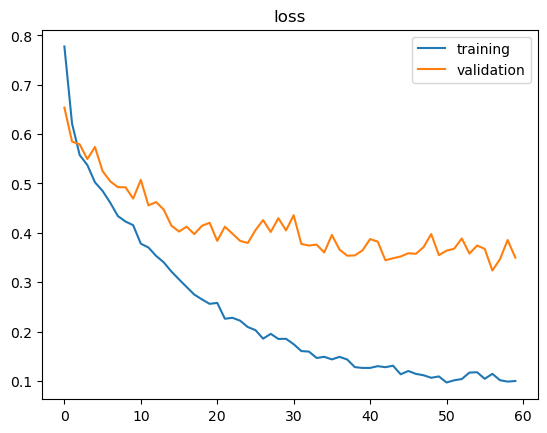

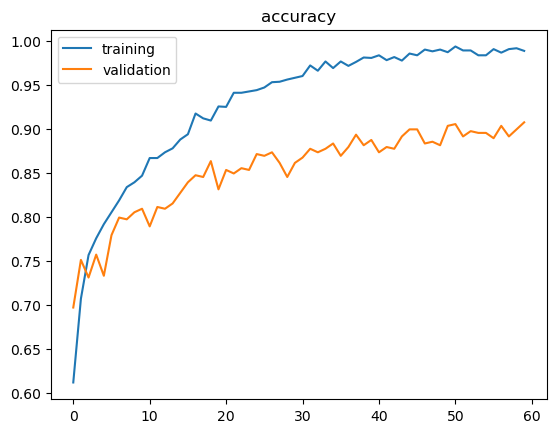

In [77]:
metrics=history.history
plt.plot(metrics['loss'],label='training')
plt.plot(metrics['val_loss'],label='validation')
plt.legend()
plt.title('loss')
plt.show()

plt.plot(metrics['accuracy'],label='training')
plt.plot(metrics['val_accuracy'],label='validation')
plt.legend()
plt.title('accuracy')
plt.show()


## Evaluating training and validation set results 

There is clear signs of overfitting in plots above made evident with the near 100% accuracy of the training set and a plateau of about 90% accuracy on the validation set. The following steps can be taken to mitigate the overfitting:

- Increase the amount of data samples (upsampling instead of downsampling)
- Better regularize the model through data augmentation (add background noise, and translations to the dataset)
- Hyperparameter search with cross validation 
- Explore different NN achitectures/Transfer Learning
- Verify the correct generation of mel spectrograms from the audio files